In [17]:
using Dagitty
using CSV
using StatsBase
using Turing
using DataFrames
using StatsPlots
using StatsBase
using Logging
using StatisticalRethinking
using Random

default(labels=false)
Logging.disable_logging(Logging.Warn);

# Easy problems

## 6E1

* Collinearity: when two features are correlated to each other, so including them both make an impression when one is not important for the prediction
* Post-treatment: when we include into the prediction features which are influencing other items
* Collider: when multiple features influence some other feature, condition on this feature might introduce spurious association between input features

## 6E2

Collinearity is very common in large datasets. One of the ways of adressing it is to do PCA of the data

## 6E3

* Fork: when one feature influences two other features. In that case, those two become correlated
* Pipe: when one feature influences the second, which in turn influence the fird. Conditioning on the second makes two independent
* Collider: two features are influence some other feature. By conditioning on this influenced feature, two becomes influenced by each other
* Descendant: collider with other feature depending from the middle one. 

## 6E4

# Medium problems

## 6M1

In [2]:
g = Dagitty.DAG(
    :X => :Y,
    :U => :X, :A => :U,
    :A => :C, :C => :Y,
    :U => :B, :C => :B,
    :V => :C, :V => :Y
)

DAG: {7, 9} directed simple Int64 graph with labels [:A, :B, :C, :U, :V, :X, :Y])


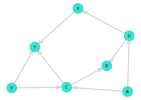

In [4]:
drawdag(g)

There are four paths - every path from the book text contain the alternative via V node

In [6]:
all_backdoor_adjustment_sets(g, :X, :Y)

3-element Vector{Vector{Symbol}}:
 [:A]
 [:U]
 [:C, :V]

## 6M2

In [26]:
Random.seed!(1)
N = 1000

X = rand(Normal(1, 1), N)
Z = rand(MvNormal(X, 0.3))
println("cor(X, Z) = $(cor(X, Z))")
Y = rand(MvNormal(Z .+ 5, 0.2))
d = DataFrame(:X => X, :Z => Z, :Y => Y)
precis(d)

cor(X, Z) = 0.9549813968737713
┌───────┬─────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%       histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     X │ 0.9707  1.0003  -0.5934  1.0047  2.5604        ▁▁▄██▃▁▁ │
│     Z │ 0.9676  1.0565  -0.7441  1.0023  2.6057  ▁▁▁▁▃▅▆██▆▄▂▁▁ │
│     Y │ 5.9725  1.0818   4.2118  6.0036  7.7008        ▁▁▄██▄▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


In [27]:
Random.seed!(4)

@model function model_6m2(X, Z, Y)
    a ~ Normal()
    bX ~ Normal()
    bZ ~ Normal()
    mu = @. a + bX*X + bZ*Z
    σ ~ Exponential()
    Y ~ MvNormal(mu, σ)
end

m6m2_ch = sample(model_6m2(d.X, d.Z, d.Y), NUTS(), 1000)
m6m2 = DataFrame(m6m2_ch)
precis(m6m2)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  5.0027  0.0091   4.9892   5.0024   5.018  ▁▁▁▃▆▆█▇▄▃▂▁▁ │
│    bX │ -0.0343  0.0218  -0.0702  -0.0337  0.0013        ▁▃▇█▅▂▁ │
│    bZ │  1.0364   0.021   1.0036   1.0358  1.0698  ▁▁▁▃▆███▆▄▂▁▁ │
│     σ │  0.2071  0.0047   0.1996    0.207  0.2146        ▁▂▆█▄▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Ok, looks like everything is fine here. Model assigned X low score because by observing Z, there is not very useful to know X. This is similar to colinearity effect, but not surprising from the relation chart

## 6M3

* (top-left): Z and A (wrong, only Z)
* (top-right): Z and A (wrong, none needed)
* (bot-left): A (wrong, none needed)
* (bot-right): Z (wrong: A)

Ah, need to reread this section

In [3]:
g = DAG(:X => :Y, :Z => :X, :Z => :Y, :A => :Z, :A => :Y)
all_backdoor_adjustment_sets(g, :X, :Y)

1-element Vector{Vector{Symbol}}:
 [:Z]

In [4]:
g = DAG(:X => :Y, :X => :Z, :Z => :Y, :A => :Z, :A => :Y)
all_backdoor_adjustment_sets(g, :X, :Y)

1-element Vector{Vector{Symbol}}:
 []

In [5]:
g = DAG(:X => :Y, :X => :Z, :Y => :Z, :A => :Z, :A => :X)
all_backdoor_adjustment_sets(g, :X, :Y)

1-element Vector{Vector{Symbol}}:
 []

In [6]:
g = DAG(:X => :Y, :X => :Z, :Z => :Y, :A => :Z, :A => :X)
all_backdoor_adjustment_sets(g, :X, :Y)

1-element Vector{Vector{Symbol}}:
 [:A]

# Hard problems

## 6H1

In [15]:
g = DAG(:S => :W, :S => :A, :S => :M, :A => :M, :M => :D, :A => :D, :W => :D)
all_backdoor_adjustment_sets(g, :W, :D)

2-element Vector{Vector{Symbol}}:
 [:S]
 [:A, :M]

Let's use S variable to get the causal influence

In [27]:
d = DataFrame(CSV.File("../data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:W] = standardize(ZScoreTransform, convert.(Float64, d.WaffleHouses));

In [29]:
@model function model_m6h1(W, South, D)
    a ~ Normal()
    bW ~ Normal()
    bS ~ Normal()
    μ = @. a + bW * W + bS * South
    σ ~ Exponential()
    D ~ MvNormal(μ, σ)
end

m6h1_ch = sample(model_m6h1(d.W, d.South, d.D), NUTS(), 1000)
m6h1 = DataFrame(m6h1_ch)
precis(m6h1)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ -0.1708  0.1751  -0.4336  -0.1695  0.1024   ▁▁▁▃▅██▇▄▂▁▁▁ │
│    bS │  0.6097  0.3988  -0.0777   0.6224  1.2198          ▁▂▅█▃▁ │
│    bW │  0.0644  0.1945  -0.2386    0.059  0.3884  ▁▁▁▂▆▇█▇▅▃▂▁▁▁ │
│     σ │  0.9758  0.1045   0.8152   0.9712  1.1522        ▁▄█▆▂▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


So, we can see that waffle houses are not very correlated with divorce, but strongly correlated with South state feature.

## 6H2

Ok, let's check another adjustment set: [A, M]

In [33]:
d = DataFrame(CSV.File("../data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:W] = standardize(ZScoreTransform, convert.(Float64, d.WaffleHouses));

In [34]:
@model function model_m6h2(W, A, M, D)
    a ~ Normal()
    bW ~ Normal()
    bA ~ Normal()
    bM ~ Normal()
    μ = @. a + bW*W + bA*A + bM*M
    σ ~ Exponential()
    D ~ MvNormal(μ, σ)
end

m6h2_ch = sample(model_m6h2(d.W, d.A, d.M, d.D), NUTS(), 1000)
m6h2 = DataFrame(m6h2_ch)
precis(m6h2)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.0017  0.1109  -0.1742   0.0022   0.1791      ▁▁▄██▄▁▁ │
│    bA │ -0.6229  0.1576  -0.8691  -0.6254  -0.3662   ▁▁▂▄▇██▅▃▁▁ │
│    bM │   -0.08  0.1572  -0.3251  -0.0815   0.1645  ▁▁▂▅██▇▄▁▁▁▁ │
│    bW │  0.1784  0.1214  -0.0042    0.174   0.3817    ▁▁▂▅█▇▃▁▁▁ │
│     σ │  0.8153  0.0856   0.6901   0.8093   0.9624  ▁▁▃▆██▆▄▂▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Ok, we have weird result here: waffle houses are important for prediction of divorce rate

Maybe Southness of the state affects divorce rate?

In [38]:
g = DAG(:S => :W, :S => :A, :S => :M, :A => :M, :M => :D, :A => :D, :W => :D, :S => :D)
all_backdoor_adjustment_sets(g, :W, :D)

1-element Vector{Vector{Symbol}}:
 [:S]

In [39]:
@model function model_m6h2_1(W, A, M, South, D)
    a ~ Normal()
    bW ~ Normal()
    bA ~ Normal()
    bM ~ Normal()
    bS ~ Normal()
    μ = @. a + bW*W + bA*A + bM*M + bS*South
    σ ~ Exponential()
    D ~ MvNormal(μ, σ)
end

m6h2_1_ch = sample(model_m6h2_1(d.W, d.A, d.M, d.South, d.D), NUTS(), 1000)
m6h2_1 = DataFrame(m6h2_1_ch)
precis(m6h2_1)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │ -0.0763  0.1431   -0.301  -0.0845   0.1616     ▁▂▄██▆▃▂▁▁▁ │
│    bA │ -0.5991  0.1669  -0.8665  -0.5996  -0.3316  ▁▁▁▁▃▆██▆▃▁▁▁▁ │
│    bM │ -0.0703  0.1563  -0.3166  -0.0681   0.1797   ▁▁▁▁▂▅██▇▃▁▁▁ │
│    bS │  0.2747  0.3242  -0.2255   0.2812   0.8068    ▁▁▁▂▅▇█▇▃▂▁▁ │
│    bW │  0.1027  0.1505  -0.1438    0.107   0.3393      ▁▁▂▆██▆▃▁▁ │
│     σ │  0.8153  0.0896   0.6841   0.8063   0.9749        ▁▂██▃▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Ok, looks like southness is really important, more important than waffles houses counts

## 6H3

In [41]:
g = DAG(:A => :F, :F => :G, :G => :W, :F => :W)

DAG: {4, 4} directed simple Int64 graph with labels [:A, :F, :G, :W])


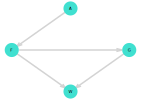

In [42]:
drawdag(g, [1, 0, 2, 1], [0, 1, 1, 2])

In [43]:
all_backdoor_adjustment_sets(g, :A, :W)

1-element Vector{Vector{Symbol}}:
 []

In [44]:
implied_conditional_independencies(g)

4-element Vector{ConditionalIndependence}:
 ConditionalIndependence(:A, :G, [:F])
 ConditionalIndependence(:A, :G, [:F, :W])
 ConditionalIndependence(:A, :W, [:F])
 ConditionalIndependence(:A, :W, [:F, :G])

In [45]:
d = DataFrame(CSV.File("../data/foxes.csv"))
d[!,:A] = standardize(ZScoreTransform, d.area)
d[!,:W] = standardize(ZScoreTransform, d.weight);

In [46]:
@model function model_6h3(A, W)
    a ~ Normal(0, 0.5)
    b ~ Normal(0, 1)
    μ = @. a + b * A
    σ ~ Exponential()
    W ~ MvNormal(μ, σ)
end

model_6h3 (generic function with 2 methods)

In [47]:
pri_ch = sample(model_6h3(d.A, d.W), Prior(), 1000)
pri = DataFrame(pri_ch)
precis(pri)

┌───────┬─────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%  histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ -0.0025  0.5112   -0.846  0.0226  0.7868   ▁▁▁▃██▃▁ │
│     b │  0.0185  1.0248  -1.6272  0.0276  1.6577  ▁▁▁▄██▄▁▁ │
│     σ │  0.9721  0.9694   0.0634  0.6669  2.8637   █▄▂▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


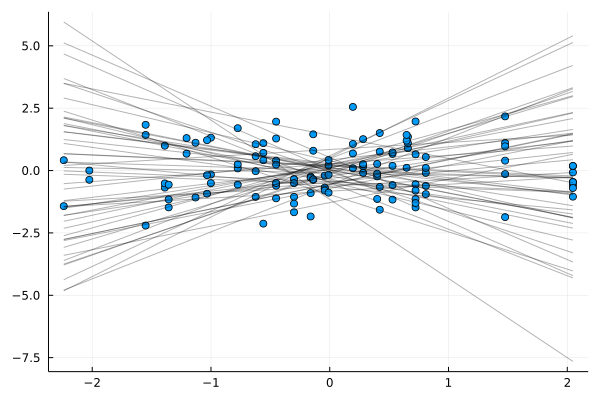

In [48]:
p = scatter(d.A, d.W)
for r in first(eachrow(pri), 50)
    plot!(x -> r.a + x * r.b; c=:black, alpha=0.3)
end
p

In [49]:
m6h3_ch = sample(model_6h3(d.A, d.W), NUTS(), 1000)
m6h3 = DataFrame(m6h3_ch)
precis(m6h3)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ -0.0037  0.0935  -0.1613  -0.0011  0.1449   ▁▁▁▂▃▆██▅▃▂▁▁ │
│     b │  0.0166  0.0909  -0.1317   0.0197  0.1605  ▁▁▂▃▅▇█▇▄▂▁▁▁▁ │
│     σ │   1.006  0.0666   0.9053   1.0041  1.1129       ▁▂▆██▆▂▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


In [50]:
seq_a = range(extrema(d.A)...; length=30)
μ = StatisticalRethinking.link(m6h3, [:a, :b], seq_a)
μ = hcat(μ...);
μ_mean = mean.(eachcol(μ));
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...);

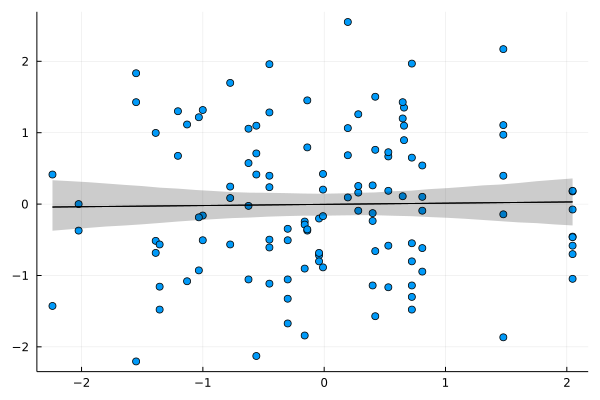

In [51]:
scatter(d.A, d.W)
plot!(seq_a, [μ_mean μ_mean]; fillrange=μ_PI, c=:black, fillalpha=0.2)

So, almost no relation between area and weight of foxes

## 6H4

In [52]:
d = DataFrame(CSV.File("../data/foxes.csv"))
d[!,:A] = standardize(ZScoreTransform, d.area)
d[!,:F] = standardize(ZScoreTransform, d.avgfood)
d[!,:W] = standardize(ZScoreTransform, d.weight);

In [53]:
@model function model_6h4(A, F, W)
    # A -> F
    aA ~ Normal(0, 0.5)
    bA ~ Normal(0, 1)
    μF = @. aA + bA * A
    σF ~ Exponential()
    F ~ MvNormal(μF, σF)
    
    # F -> W
    aF ~ Normal(0, 0.5)
    bF ~ Normal(0, 1)
    μW = @. aF + bF * F
    σW ~ Exponential()
    W ~ MvNormal(μW, σW)
end

model_6h4 (generic function with 2 methods)

In [54]:
pri_ch = sample(model_6h4(d.A, d.F, d.W), Prior(), 1000)
pri = DataFrame(pri_ch)
precis(pri)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│    aA │  -0.022  0.4935  -0.8424  -0.0338  0.8211         ▁▃██▃▁▁ │
│    aF │  0.0101  0.4977  -0.7842   0.0031  0.7996         ▁▃██▄▁▁ │
│    bA │ -0.0011  0.9747  -1.6119  -0.0003  1.5732  ▁▁▁▁▂▄▇██▇▄▂▁▁ │
│    bF │ -0.0388  1.0389  -1.6964  -0.0047  1.6215       ▁▁▁▄██▄▁▁ │
│    σF │  1.0279  1.0546    0.049   0.7057  3.0579        █▃▂▁▁▁▁▁ │
│    σW │  0.9287   0.956   0.0596   0.6305   2.772  █▅▃▂▁▁▁▁▁▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


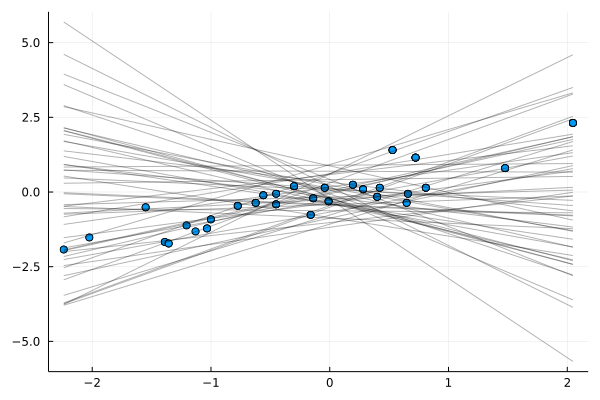

In [55]:
p = scatter(d.A, d.F)
for r in first(eachrow(pri), 50)
    plot!(x -> r.aA + x * r.bA; c=:black, alpha=0.3)
end
p

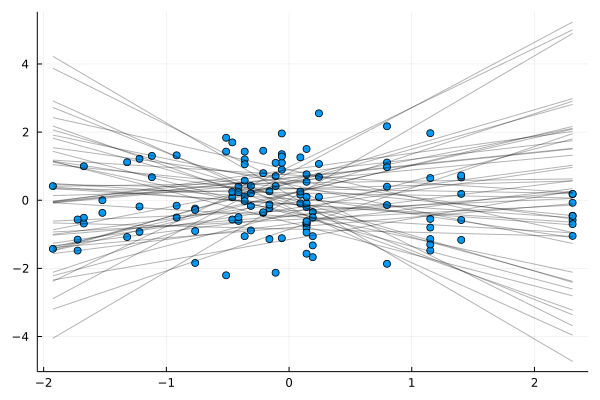

In [56]:
p = scatter(d.F, d.W)
for r in first(eachrow(pri), 50)
    plot!(x -> r.aF + x * r.bF; c=:black, alpha=0.3)
end
p

In [57]:
m6h4_ch = sample(model_6h4(d.A, d.F, d.W), NUTS(), 1000)
m6h4 = DataFrame(m6h4_ch)
precis(m6h4)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%     histogram │
├───────┼────────────────────────────────────────────────────────┤
│    aA │   0.001  0.0428  -0.0645  0.0006   0.071        ▁▃██▃▁ │
│    aF │  0.0057  0.0959  -0.1516  0.0052  0.1552  ▁▁▂▃▆██▇▄▂▁▁ │
│    bA │  0.8808  0.0441   0.8105  0.8806  0.9486       ▁▁▄█▅▁▁ │
│    bF │ -0.0269  0.0955  -0.1814  -0.026  0.1183      ▁▁▅█▇▂▁▁ │
│    σF │  0.4754  0.0322   0.4283  0.4724  0.5292  ▁▁▄▇█▆▄▂▁▁▁▁ │
│    σW │  1.0132  0.0687   0.9083  1.0089  1.1305    ▁▂▄██▅▃▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


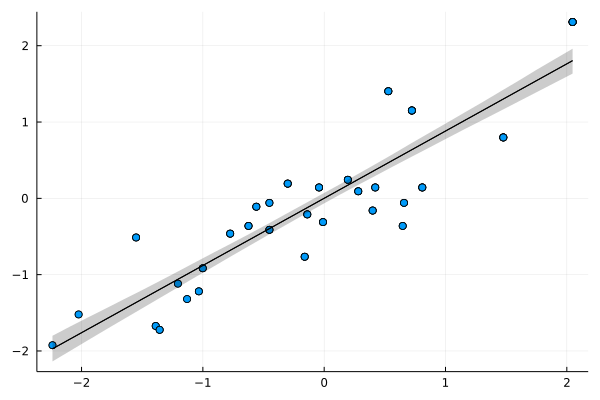

In [60]:
seq_a = range(extrema(d.A)...; length=30)
μF = StatisticalRethinking.link(m6h4, [:aA, :bA], seq_a)
μF = hcat(μF...);
μF_mean = mean.(eachcol(μF));
μF_PI = PI.(eachcol(μF))
μF_PI = vcat(μF_PI'...);

scatter(d.A, d.F)
plot!(seq_a, [μF_mean μF_mean]; fillrange=μF_PI, c=:black, fillalpha=0.2)

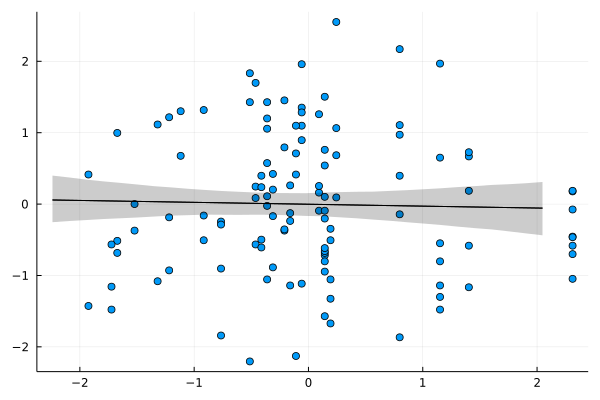

In [61]:
seq_f = range(extrema(d.F)...; length=30)
μW = StatisticalRethinking.link(m6h4, [:aF, :bF], seq_f)
μW = hcat(μW...);
μW_mean = mean.(eachcol(μW));
μW_PI = PI.(eachcol(μW))
μW_PI = vcat(μW_PI'...);

scatter(d.F, d.W)
plot!(seq_a, [μW_mean μW_mean]; fillrange=μW_PI, c=:black, fillalpha=0.2)

In [62]:
@model function model_6h4a(A, F, W)
    a ~ Normal(0, 0.5)
    bF ~ Normal(0, 1)
    bA ~ Normal(0, 1)
    μ = @. a + bF*F + bA*A
    σ ~ Exponential()
    W ~ MvNormal(μ, σ)
end

model_6h4a (generic function with 2 methods)

In [63]:
m6h4a_ch = sample(model_6h4a(d.A, d.F, d.W), NUTS(), 1000)
m6h4a = DataFrame(m6h4a_ch)
precis(m6h4a)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.0015   0.089  -0.1368   0.0041  0.1471  ▁▁▁▁▁▃▆██▆▃▂▁▁ │
│    bA │  0.1831  0.1988  -0.1587   0.1888  0.4913  ▁▁▂▃▅▆██▆▄▂▁▁▁ │
│    bF │ -0.1786  0.1984  -0.4947  -0.1861  0.1475   ▁▁▂▃▅██▆▅▂▁▁▁ │
│     σ │  1.0104  0.0687   0.9076   1.0064  1.1214     ▁▂▅█▇▆▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


So, it is incorrect to put both A and F into W regression. 

Looks like Area and Food are strongly related (which is logical). But Food and Weight are not related.

## 6H5

In [64]:
all_backdoor_adjustment_sets(g, :G, :W)

1-element Vector{Vector{Symbol}}:
 [:F]

In [65]:
d[!,:G] = standardize(ZScoreTransform, convert.(Float64, d.groupsize));

In [66]:
@model function model_6h5(G, F, W)
    a ~ Normal(0, 0.5)
    bG ~ Normal(0, 1)
    bF ~ Normal(0, 1)
    μ = @. a + bG*G + bF*F
    σ ~ Exponential()
    W ~ MvNormal(μ, σ)
end

model_6h5 (generic function with 2 methods)

In [67]:
m6h5_ch = sample(model_6h5(d.G, d.F, d.W), NUTS(), 1000)
m6h5 = DataFrame(m6h5_ch)
precis(m6h5)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ -0.0076  0.0873  -0.1483  -0.0043   0.1272   ▁▁▁▂▄▅██▅▃▁▁ │
│    bF │  0.5798  0.1955   0.2678   0.5777   0.8911  ▁▁▃▆▆██▇▄▂▁▁▁ │
│    bG │ -0.6751  0.1914  -0.9773   -0.677  -0.3634  ▁▁▂▄▇██▇▅▃▁▁▁ │
│     σ │  0.9605  0.0657   0.8623   0.9562   1.0654    ▁▁▅██▆▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘
